# The purpose of this notebook is to run a benchmark test on the different size transition matrices to find a good size to have our code run on

In [37]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import normalize
from random import randint
import time
import seaborn as sns
import math

import pycuda.autoinit
import pycuda.driver as cuda

from pycuda.compiler import SourceModule


from numpy import linalg as LA

from discreteMarkovChain import markovChain

import random

fig_prefix = "../figures/2018-08-14_jw-benchmark_test_"
data_prefix = "../data/2018-08-14_jw-benchmark_test_"

In [38]:
RUN_CUDA = 0
RUN_HITTING_TIME = 1

## Define the functions used in the test

In [39]:
def createRandomSparseMatrix(n):
    new_matrix = sparse.dok_matrix( (n,n), dtype=np.float32)
    empty_percentage = 1 - 0.993707205845
    total_non_zeroes = empty_percentage * (n*n)

    min_number_of_events = 1 #This is arbitrary
    max_number_of_events = 1000 #This is arbitrary
    non_zero_locations = []
    #Manually add along the diagnol so that way all rows have an action
    for i in range(n):
        non_zero_locations.append((i,i))
    while (len(non_zero_locations) < total_non_zeroes):
        new_x = randint(0, n-1)
        new_y = randint(0, n-1)
        if (new_x, new_y) not in non_zero_locations:
            non_zero_locations.append((new_x,new_y))
    for coordinate in non_zero_locations:
        new_matrix[coordinate[0], coordinate[1]] = randint(min_number_of_events,max_number_of_events)
    normalized_new_matrix = normalize(new_matrix, norm='l1', axis=1)
    return normalized_new_matrix

### The following are for non-cuda implementation

In [40]:
def crossproduct_sparse(P,Q, size):
    start_time = time.time()
    k = size #K is used for the number of states each configuration can be in. This needs to be the same for all configurations
            # And this isnt a bad assumption because all of the configurations should be discretized the same way
    if(P.get_shape()[0] != P.get_shape()[1] or Q.get_shape()[0] != Q.get_shape()[1]):
        print("[Error] the transition matrices should be square!")
        print(P.get_shape())
        print(Q.get_shape())
        return None
    
    length_P = P.get_shape()[0]
    length_Q = Q.get_shape()[0]
    
    d_M1 = {}
    for key in P.keys():
        new_key = key + ((1,),)
        d_M1[new_key] = P.get(key)

    d_M2 = {}
    for key in Q.keys():
        new_key = key + ((2,),)
        d_M2[new_key] = Q.get(key)
    print("preparing all the data took {} seconds".format(time.time()-start_time))   
    PQ = sparse.dok_matrix( (length_P*length_Q,length_P*length_Q), dtype=np.float32)
    for key_1,value_1 in d_M1.iteritems():
        for key_2,value_2 in d_M2.iteritems():
            #The new key is in the format of (x_1,y_1,yaw_1,x_2,y_2,yaw_2,...,x_n,y_n,yaw_n, [1,2,...,n])
            #Note: The (x,y,yaw) should also just be a map3dTo1D
            #By doing this format we can track back the states of different configurations
            combined_key = key_1[:-1] + key_2[:-1] + (key_1[-1] + key_2[-1],)
            x_map = y_map = 0
            for i in range(len(key_1[-1] + key_2[-1],)):
                x_map += combined_key[2 * i] * (k ** i)
                y_map += combined_key[1 + 2 * i] * (k ** i)
            PQ[x_map,y_map] = value_1 * value_2
    print("completing took {} seconds".format(time.time()-start_time))           
    return PQ

### The following are for cuda implementation

In [41]:
def cuda_sparse(sparse_M1, sparse_M2, size):
    gpu_d = {}

    d_M1 = {}

    for key in sparse_M1.keys():
        new_key = key + ((1,),)
        d_M1[new_key] = sparse_M1.get(key)

    d_M2 = {}
    for key in sparse_M2.keys():
        new_key = key + ((2,),)
        d_M2[new_key] = sparse_M2.get(key)
    counter = 0
    flag = 1
    l_M1 = []
    l_M2 = []
    v_M1 = []
    v_M2 = []
    for key_1,value_1 in d_M1.iteritems():
        for key_2,value_2 in d_M2.iteritems():
            #The new key is in the format of (x_1,y_1,yaw_1,x_2,y_2,yaw_2,...,x_n,y_n,yaw_n, [1,2,...,n])
            #Note: The (x,y,yaw) should also just be a map3dTo1D
            #By doing this format we can track back the states of different configurations
            combined_key = key_1[:-1] + key_2[:-1] + (key_1[-1] + key_2[-1],)
            gpu_d[counter] = combined_key
            counter += 1
            if flag:
                v_M2.append(value_2)
                l_M2.append(key_2)
        flag = 0
        l_M1.append(key_1)
        v_M1.append(value_1)
        
    out_N = max(len(v_M1),len(v_M2))
    M1 = np.squeeze(np.asarray(v_M1))
    M2 = np.squeeze(np.asarray(v_M2))
    M1 = M1.astype(np.float32)
    M2 = M2.astype(np.float32)
    M1_gpu = cuda.mem_alloc(M1.nbytes)
    M2_gpu = cuda.mem_alloc(M2.nbytes)

    Out = np.zeros( (out_N, out_N))
    Out = np.squeeze(np.asarray(Out))
    Out = Out.astype(np.float32)
    Out_gpu = cuda.mem_alloc(Out.nbytes)
    
    #Transfer the data over
    cuda.memcpy_htod(M1_gpu, M1)
    cuda.memcpy_htod(M2_gpu, M2)

    #Create the kernel to be used
    s = """
    __global__ void cross_sparse_product(float* A, float *B, float *C, int size)
    {
        int n = size;
        int l = threadIdx.x;
        int k = threadIdx.y;

        if(l < n && k < n)
        {
            A[k*n + l] = (B[l]) * (C[k]);  
        }

    }
    """
    mod = SourceModule(s)
    
    NUMBER_OF_THREADS = 1024
    grid_size = int(math.ceil(float(out_N * out_N) / float(NUMBER_OF_THREADS)))

    grid_size = int(math.ceil(math.sqrt(grid_size)))
    grid_size

    func = mod.get_function("cross_sparse_product")
    run_time = time.time()
    # call the kernel on the card
    func( Out_gpu, M1_gpu, M2_gpu, np.int32(out_N), grid=(grid_size,grid_size), block=(32,32,1) )
    # copy back the result
    cuda.memcpy_dtoh(Out, Out_gpu)
    gpu_dense_time = time.time()-run_time

    #Convert results into sparse matrix
    N = original_M1.shape[0]
    M = original_M2.shape[1]


    k = N
    return (0,0)
    dense_out_matrix = np.zeros( (N*M, N*M) )
    for value, new_key in gpu_d.iteritems():
        x_map = 0
        y_map = 0
        for i in range(len(new_key[-1])):
            x_map += new_key[2*i] * (k**i)
            y_map += new_key[1 +2*i] * (k**i)
        dense_out_matrix[x_map][y_map] = Out[value%out_N][value/out_N]
    return dense_out_matrix

In [42]:
def getHittingTime(M,M1):

    mc2=markovChain(M)
    M3=mc2.getTransitionMatrix()
     
    
    ## Target states -- diagonal states of final Markov chain
    diagonaltargetset=[0]
    diag=1
    for i in range(1,len(M)):
        if i==diag*len(M1)+diag:
            diagonaltargetset.append(i)
            diag=diag+1
    #print diagonaltargetset
    
    ## Target states
    hittingset=diagonaltargetset
    #hittingset=[0,3]

    one = np.ones(len(M))
    one[hittingset] = 0
    
    ##k1 = np.zeros(len(M))
    ##for i in range(100):
    ##    k1 = M3.dot(k1)+one1
    ##    k1[hittingset1]  = 0
    ##    #print k1
    ##
    ##print(k1)

    mask = np.zeros(len(M))
    for i in range(len(M)):
        if i in hittingset:
            mask[i]=1

        
    k1 = np.zeros(len(M))
    k2 = one + M3.dot(k1)
    i = 0

    while(LA.norm(k1-k2)>1e-6):
        k1=k2
        k2 = one + M3.dot(k1)
        np.putmask(k2, mask, 0)
        i += 1

    print 'Hitting Time',(k2)

In [43]:
def randomWalkMatrix(size):
    M = np.zeros( (size,size) )
    # defining the number of steps
    n = 100000
    x = size/2
    y = size/2
    # filling the coordinates with random variables
    for i in range(1, n):
        val = random.randint(1, 4)
        if val == 1:
            x += 1
            if(x >= size):
                x = size-1
            M[x][y] += 1
        elif val == 2:
            x -= 1
            if(x < 0):
                x = 0
            M[x][y] += 1
        elif val == 3:
            y += 1
            if(y >= size):
                y = size-1
            M[x][y] += 1
        else:
            y -= 1
            if(y < 0):
                y=0
            M[x][y] += 1
    normalized_new_matrix = normalize(M, norm='l1', axis=1)
    return normalized_new_matrix

## Start the test

In [44]:
max_waiting_time = 60 #In seconds
results = []
results_memory = []
continue_flag = 1
size = 2

In [45]:
#The test will work like this. We will keep running until there exists a test that goes over the time constraint given.
while(continue_flag == 1 and RUN_CUDA == 0):
    test_matrix = createRandomSparseMatrix(size)
    sparse_test_matrix = sparse.dok_matrix(test_matrix)
    test_time_start = time.time()
    crossproduct_sparse(sparse_test_matrix,sparse_test_matrix,size)
    results.append( (size, time.time() - test_time_start) )
    if(time.time() - test_time_start > max_waiting_time):
        continue_flag = 0
    size = size * 2

In [46]:
#The test will work like this. We will keep running until there exists a test that goes over the time constraint given.
while(continue_flag == 1 and RUN_CUDA == 1):
    original_M1= createRandomSparseMatrix(size)
    original_M2= original_M1
    #original_M1, and original_M2 need to be here for the code (it checks the size of the original matrices)
    sparse_test_matrix = sparse.dok_matrix(original_M1)
    test_time_start = time.time()
    sizes = cuda_sparse(sparse_test_matrix,sparse_test_matrix,size)
    results.append( (size, time.time() - test_time_start) )
    if(time.time() - test_time_start > max_waiting_time):
        continue_flag = 0
    results_memory.append(sizes)
    size = size * 2

In [47]:
if RUN_HITTING_TIME == 1:
    size = 4
    original_M1 = randomWalkMatrix(size)
    original_M2= original_M1
    sparse_test_matrix = sparse.dok_matrix(original_M1)
    test_time_start = time.time()
    M = crossproduct_sparse(sparse_test_matrix,sparse_test_matrix,size)
    getHittingTime(M, original_M1)
    print("Time taken = {}".format(time.time()-test_time_start))

In [48]:
results

[(2, 0.03646206855773926),
 (4, 0.0015001296997070312),
 (8, 0.002084016799926758),
 (16, 0.003047943115234375),
 (32, 0.0035789012908935547),
 (64, 0.006412029266357422),
 (128, 0.017145156860351562),
 (256, 0.5305571556091309),
 (512, 3.155372142791748),
 (1024, 180.23250794410706)]

In [49]:
results_memory

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0)]

In [50]:
df = pd.DataFrame(results, columns=['n', 'seconds'])
df['log(seconds)'] = np.log(df['seconds'])
df

,n,seconds,log(seconds)
0,2,0.036462,-3.311483
1,4,0.001500,-6.502204
2,8,0.002084,-6.173458
3,16,0.003048,-5.793288
4,32,0.003579,-5.632699
5,64,0.006412,-5.049579
6,128,0.017145,-4.066040
7,256,0.530557,-0.633828
8,512,3.155372,1.149106
9,1024,180.232508,5.194248


In [51]:
df_memory = pd.DataFrame(results_memory, columns=['dense', 'sparse'])
df_memory['Saved'] = 1 - (df_memory['sparse']/df_memory['dense'])
df_memory['n'] = df['n']
df_memory

,dense,sparse,Saved,n
0,0,0,NaN,2
1,0,0,NaN,4
2,0,0,NaN,8
3,0,0,NaN,16
4,0,0,NaN,32
5,0,0,NaN,64
6,0,0,NaN,128
7,0,0,NaN,256
8,0,0,NaN,512
9,0,0,NaN,1024


## Create the appropiate graphics

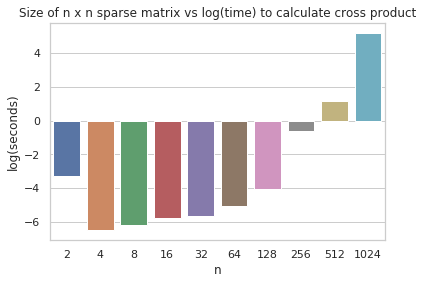

In [52]:
#Create appropiate log figure
sns.set(style="whitegrid")
ax = sns.barplot(x=df['n'], y=df['log(seconds)'], data=df).set_title('Size of n x n sparse matrix vs log(time) to calculate cross product')
ax.figure.savefig(fig_prefix + "log_seconds_for_completion")

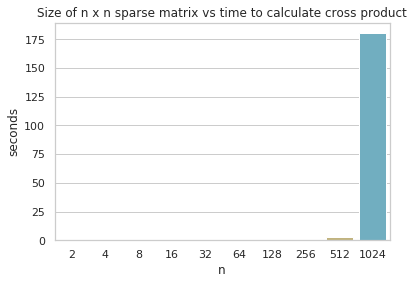

In [53]:
#Create appropiate figure
sns.set(style="whitegrid")
ax = sns.barplot(x=df['n'], y=df['seconds'], data=df).set_title('Size of n x n sparse matrix vs time to calculate cross product')
ax.figure.savefig(fig_prefix + "seconds_for_completion")

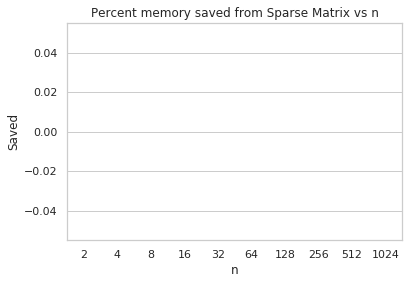

In [54]:
#Show the memory savings from sparse matrix
sns.set(style="whitegrid")
ax = sns.barplot(x=df_memory['n'], y=df_memory['Saved'], data=df_memory).set_title('Percent memory saved from Sparse Matrix vs n')
ax.figure.savefig(fig_prefix + "percent_memory_saved")